In [2]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
#from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("/home/centos/moon/ktw/Otto Group Product Classification Challenge/data/train.csv", decimal=",")
ds = data.values
ds

array([[1, 1, 0, ..., 0, 0, 'Class_1'],
       [2, 0, 0, ..., 0, 0, 'Class_1'],
       [3, 0, 0, ..., 0, 0, 'Class_1'],
       ...,
       [61876, 0, 0, ..., 0, 0, 'Class_9'],
       [61877, 1, 0, ..., 10, 0, 'Class_9'],
       [61878, 0, 0, ..., 2, 0, 'Class_9']], dtype=object)

In [4]:
x_trdata = ds[:, 1:94]
y_trdata = ds[:, 94]

In [5]:
le = LabelEncoder()
y_trdata = le.fit_transform(y_trdata).astype(int)
y_trdata

array([0, 0, 0, ..., 8, 8, 8])

In [6]:
seed = 326
ts = 0.20

sss = StratifiedShuffleSplit(n_splits=1, test_size=ts, random_state=seed)
for train_idx, test_idx in sss.split(x_trdata, y_trdata):
    x_train = x_trdata[train_idx]
    y_train = y_trdata[train_idx]
    x_val = x_trdata[test_idx]
    y_val = y_trdata[test_idx]  

In [7]:
data.isnull().sum().sum()

0

<AxesSubplot:>

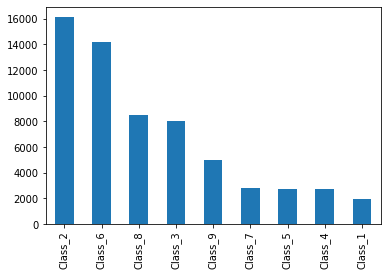

In [8]:
data["target"].value_counts().plot.bar()

In [ ]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(x_train, y_train)

In [ ]:
pred = xgb.predict_proba(x_val)
print("Validation data logloss: {}".format(log_loss(y_val, pred)))

In [ ]:
pred = xgb.predict(x_val)
accu = accuracy_score(y_val, pred)
print("Accuracy: %.2f%%" % (accu * 100.0))

In [ ]:
lr_scores = []
learning_rates = [0.345, 0.350, 0.355]

for l in learning_rates:
    tune_xgb = XGBClassifier(use_label_encoder=False, learning_rate=l)
    tune_xgb.fit(x_train, y_train)
    pred = tune_xgb.predict_proba(x_val)
    lr_scores.append(log_loss(y_val, pred))
    print("learning_rate=%.3f, logloss: %.5f" % (l, log_loss(y_val, pred)))

In [11]:
pa = {'objective':'multi:sofprob',
      'learning_rate': 0.35,
     }

In [12]:
xgb = XGBClassifier(**pa, use_label_encoder=False)
model = CalibratedClassifierCV(xgb, cv=5, method="isotonic")
model.fit(x_train, y_train)

[09:49:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:49:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:50:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:50:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    enable_categorical=False,
                                                    gamma=None, gpu_id=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=0.35,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                        

In [13]:
pred = model.predict_proba(x_val)
print("Validation data logloss: {}".format(log_loss(y_val, pred)))

Validation data logloss: 0.4628408686464133


In [14]:
test = pd.read_csv("/home/centos/moon/ktw/Otto Group Product Classification Challenge/data/test.csv", decimal=",")
ds = test.values
ds

array([[     1,      0,      0, ...,      0,      0,      0],
       [     2,      2,      2, ...,      0,      2,      0],
       [     3,      0,      1, ...,      0,      0,      1],
       ...,
       [144366,      0,      1, ...,      1,      0,      0],
       [144367,      0,      0, ...,      0,      1,      0],
       [144368,      0,      0, ...,      0,      0,      0]])

In [15]:
test.shape

(144368, 94)

In [16]:
x_test = ds[:, 1:94]
x_test

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 2,  2, 14, ...,  0,  2,  0],
       [ 0,  1, 12, ...,  0,  0,  1],
       ...,
       [ 0,  1,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [17]:
pred = model.predict_proba(x_test)
pred

array([[0.00000000e+00, 1.88199355e-01, 1.06343002e-01, ...,
        6.91058381e-03, 1.08569352e-04, 0.00000000e+00],
       [3.16431650e-03, 8.38208680e-03, 5.35171004e-04, ...,
        3.92670367e-03, 5.24648612e-01, 8.28392614e-04],
       [0.00000000e+00, 7.04736966e-05, 0.00000000e+00, ...,
        1.57883358e-04, 6.02903299e-04, 1.59141399e-04],
       ...,
       [0.00000000e+00, 5.55323526e-01, 2.49213800e-01, ...,
        6.59905955e-03, 1.01935449e-04, 0.00000000e+00],
       [0.00000000e+00, 1.99353055e-01, 8.03249086e-03, ...,
        2.21419337e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.56113289e-01, 3.01602483e-01, ...,
        8.48387658e-02, 1.01244940e-04, 4.72638293e-05]])

In [18]:
output = pd.DataFrame(pred, columns=["Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"])
output.index.name = "id"
output.index += 1
output

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
id,,,,,,,,,
1,0.000000,0.188199,0.106343,0.698009,0.000000,0.000429,0.006911,0.000109,0.000000
2,0.003164,0.008382,0.000535,0.000337,0.000216,0.457962,0.003927,0.524649,0.000828
3,0.000000,0.000070,0.000000,0.000000,0.000000,0.999010,0.000158,0.000603,0.000159
4,0.000000,0.611847,0.365047,0.021719,0.000000,0.000000,0.000161,0.000108,0.001118
5,0.131924,0.000069,0.001029,0.000182,0.000000,0.005973,0.002889,0.089794,0.768140
...,...,...,...,...,...,...,...,...,...
144364,0.653032,0.002491,0.004095,0.002956,0.000000,0.264888,0.023379,0.013318,0.035842
144365,0.000000,0.311804,0.525800,0.063729,0.000000,0.001084,0.097270,0.000100,0.000213
144366,0.000000,0.555324,0.249214,0.188328,0.000000,0.000433,0.006599,0.000102,0.000000


In [19]:
output.to_csv("/home/centos/moon/ktw/Otto Group Product Classification Challenge/data/otto_submission.csv")